In [1]:
from collections import Counter
from nltk import FreqDist
import math
import spacy
import unicodedata 
import string
import nltk.data
import pandas as pd

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
# nlp = spacy.load("en_core_web_trf")

In [2]:
text = open(r"C:/Users/darias/Desktop/Digital_humanities/maze/maze_runner.txt", "r", encoding="utf-8")
corpus = text.read()
tokenized = tokenizer.tokenize(corpus)


In [3]:
def processing_quotation_mark(corpus):
    right_quote = unicodedata.lookup('RIGHT DOUBLE QUOTATION MARK')
    left_quote = unicodedata.lookup('LEFT DOUBLE QUOTATION MARK')
    corpus = [item.replace(right_quote, '\"').replace(left_quote, '\"') for item in corpus]
    return "".join(corpus)


In [4]:
sentences = []
for line in tokenized:
    unified_quotes = processing_quotation_mark(line)
    sentences.append(unified_quotes)

In [5]:
def IDF(corpus, unique_words):

    """
    :param corpus: list of sentences
    :param unique_words: set of words from the whole corpus
    :return: dict; word : count of sentences with this word
    """

    idf_val = {}
    total_docs = len(corpus)

    for word in unique_words:
        count = 0
        for row in corpus:
            if word in row.split(" "):
                count += 1
            idf_val[word] = 1 + math.log((1+total_docs)/(1+count))
    return idf_val

In [6]:
def fit(dataset):

    """
    :param dataset: corpus; list of sentences
    :return: vocabulary: dict[word : word_count]; idfs_: IDF
    """

    unique_words = set()
    if isinstance(dataset, (list,)):
        for row in dataset:
            for word in row.split(" "):
                if len(word) < 2:
                    continue
                unique_words.add(word)
        unique_words = sorted(list(unique_words))
        vocab = {j:i for i,j in enumerate(unique_words)}
    idfs_ = IDF(dataset, unique_words)
    return vocab, idfs_
features, idfs_ = fit(sentences)

In [7]:
def transform(dataset):
    """
    :param dataset: corpus; list of sentences
    :return: tf-idf score for sentences
    """
    sentence_score = 0
    tf_idf_sentences_score = {}

    for row in range(0, len(dataset)):
        word_count = Counter(dataset[row].split(" "))
        for word in dataset[row].split(" "):
            if word in list(features.keys()):
                tf = word_count[word] / len(dataset[row].split(" "))
                tfidf = tf * idfs_[word]
                sentence_score += tfidf
        tf_idf_sentences_score[dataset[row]] = sentence_score
    return tf_idf_sentences_score

# Frequency distribution of sentences
fd = FreqDist(transform(sentences)).most_common()

f = open("most_common.txt", "w", encoding="utf-8")
unique_sentences = []
for pair in fd:
    f.write(pair[0]+"\n")
    unique_sentences.append(pair[0])
f.close()

In [18]:
# unique_sentences

# WORD2VEC + FT 

In [9]:
from gensim.models import FastText

In [10]:
import nltk
from nltk import word_tokenize
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\darias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
def remove_non_ascii_2(string):
    return string.encode('ascii', errors='ignore').decode()

def clean_text(line):
    stops = set(stopwords.words("english"))
    processed_line = line.lower()
    words = [word for word in word_tokenize(processed_line)]
    processed_line = [word for word in words if word not in stops 
                    and word not in set(string.punctuation) and word != "``"]
    return processed_line

encoded = [remove_non_ascii_2(i) for i in unique_sentences]
processed_sent = [clean_text(line) for line in encoded]
    

In [20]:
feature_size = 100
window_context = 20
min_word_count = 5
sample = 1e-3

In [21]:
# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(processed_sent, vector_size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1)

In [25]:
# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=10)]
                  for search_term in ["Maze", "Cliff", "Glade", "Thomas", "Box", "Grievers"]}
similar_words                    

{'Maze': ['daze',
  'machinery',
  'massive',
  'center',
  'enter',
  'honest',
  'couple',
  'ears',
  'connection',
  'enormous'],
 'Cliff': ['grew',
  'pole',
  'bones',
  'alone',
  'twenty',
  'monsters',
  'grin',
  'sigh',
  'grimy',
  'middle'],
 'Glade': ['glade',
  'gladers',
  'glader',
  'light',
  'doors',
  'blade',
  'walls',
  'glad',
  'glass',
  'right'],
 'Thomas': ['thomass',
  'liked',
  'hatred',
  'sucked',
  'blinked',
  'used',
  'filled',
  'missed',
  'waited',
  'rested'],
 'Box': ['leaves',
  'forget',
  'stuck',
  'jeff',
  'nobody',
  'sweet',
  'study',
  'notes',
  'shelves',
  'nerves'],
 'Grievers': ['griever',
  'grievers',
  'one',
  'last',
  'night',
  'fight',
  'might',
  'tonight',
  'everybody',
  'nights']}

In [26]:
from gensim.models import Word2Vec
model_ww = Word2Vec(processed_sent, vector_size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1)

In [29]:
# view similar words based on gensim's Word2Vec model
similar_words = {search_term: [item[0] for item in model_ww.wv.most_similar([search_term], topn=10)]
                  for search_term in ["maze", "cliff", "glade", "thomas", "box", "grievers"]}
similar_words                    

{'maze': ['theyd',
  'lovin',
  'years',
  'exit',
  'days',
  'compare',
  'sun',
  'fact',
  'solve',
  'sections'],
 'cliff': ['slid',
  'running',
  'three',
  'massive',
  'group',
  'ahead',
  'courtyard',
  'square',
  'glass',
  'swung'],
 'glade': ['walls',
  'doors',
  'sky',
  'made',
  'two',
  'outside',
  'sounds',
  'closing',
  'light',
  'moving'],
 'thomas': ['look',
  'almost',
  'someone',
  'winston',
  'question',
  'anger',
  'teresa',
  'surprised',
  'others',
  'thoughts'],
 'box': ['half',
  'ready',
  'expecting',
  'forced',
  'sigh',
  'slammer',
  'pointing',
  'gave',
  'dinner',
  'faced'],
 'grievers': ['maze',
  'one',
  'days',
  'years',
  'fight',
  'lovin',
  'way',
  'solve',
  'night',
  'survive']}

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=False)
P = pca.fit_transform(wvs)
labels = words


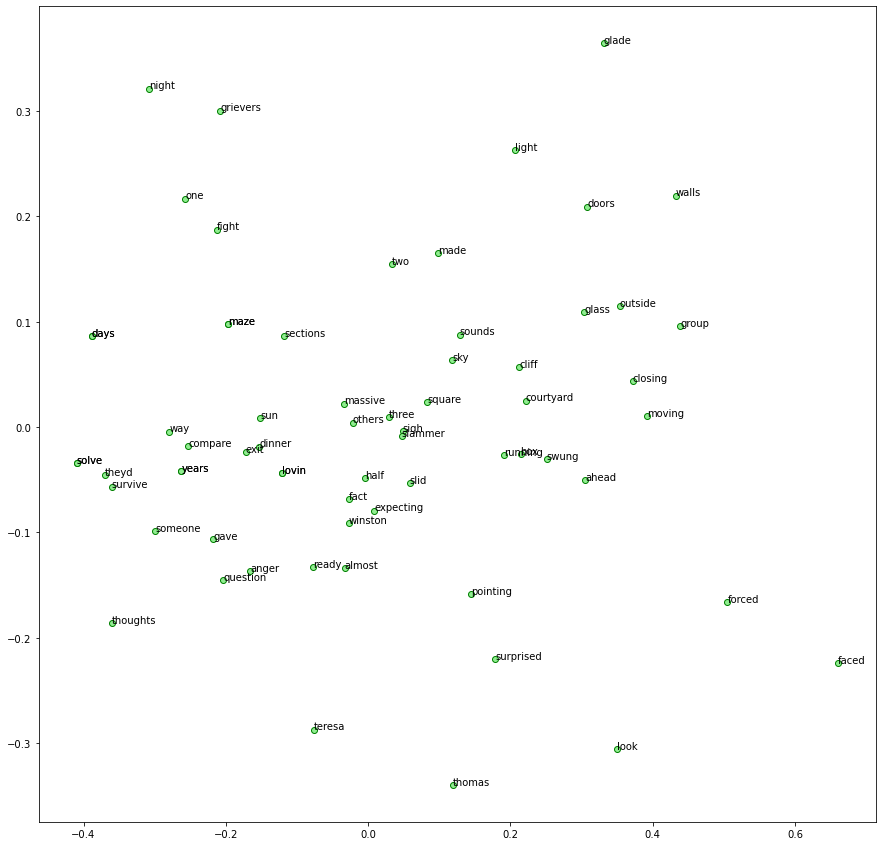

In [34]:
plt.figure(figsize=(15, 15))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

c:\Users\darias\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\darias\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


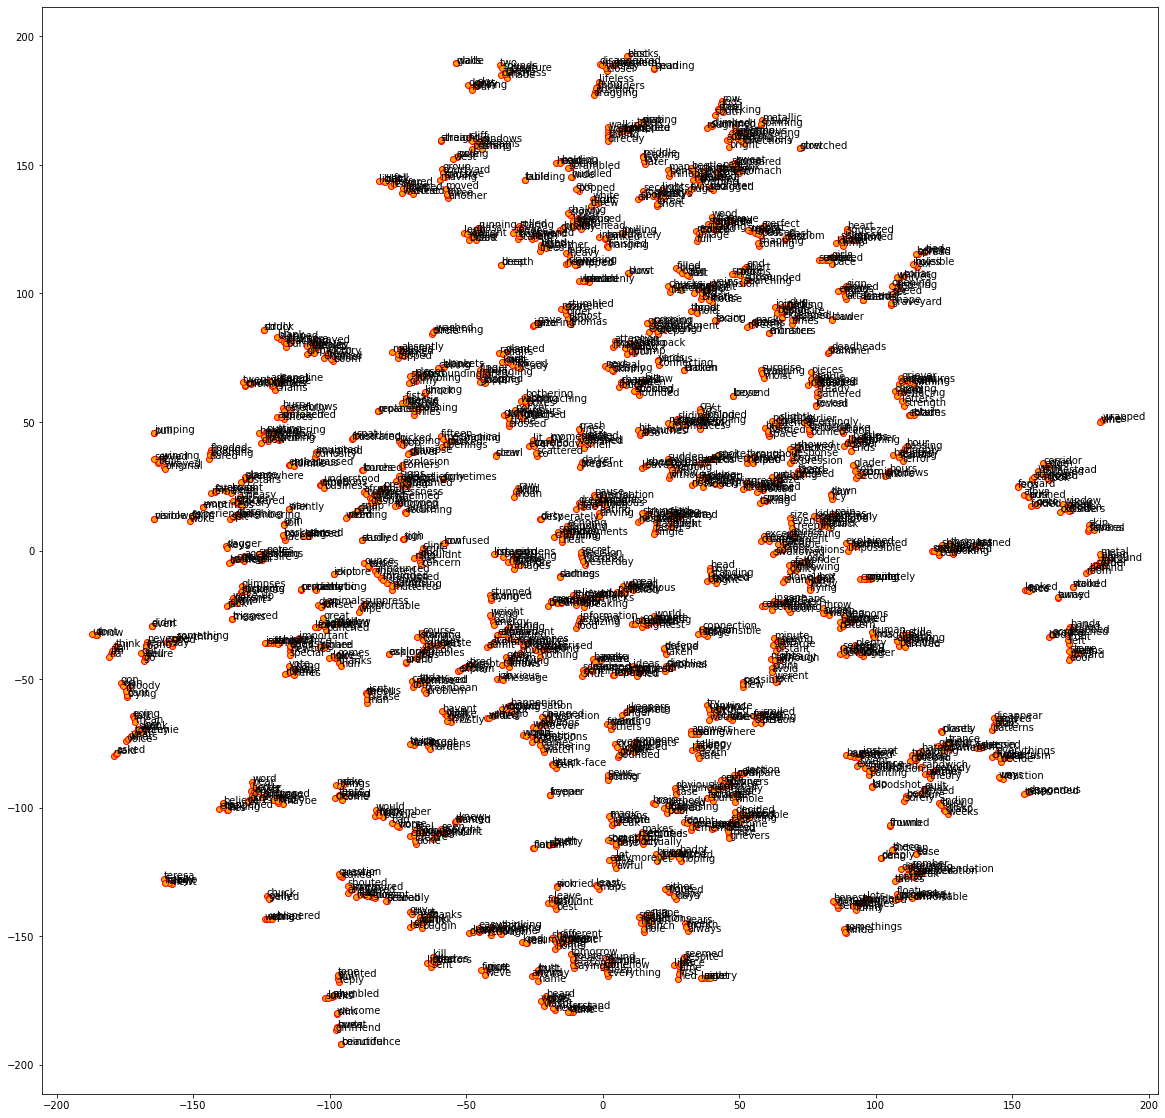

In [35]:
# visualize embeddings
from sklearn.manifold import TSNE

words = model_ww.wv.index_to_key
wvs = model_ww.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=False)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    

# Create a custom mini corpus for all sentences with "maze", "cliff", "glade"

In [10]:
text = open(r"C:\Users\darias\Desktop\Digital_humanities\most_common.txt", "r", encoding="utf-8")
corpus = text.read()
tokenized = tokenizer.tokenize(corpus)

In [11]:
key_words = [
'theyd',
'lovin',
'years',
'exit',
'days',
'compare',
'sun',
'fact',
'solve',
'sections',
'many',
'slid',
'running',
'three',
'massive',
'group',
'ahead',
'courtyard',
'square',
'glass',
'swung',
'walls',
'doors',
'sky',
'made',
'two',
'outside',
'sounds',
'closing',
'light',
'moving',
'look',
'almost',
'someone',
'winston',
'question',
'anger',
'teresa',
'surprised',
'others',
'thoughts',
'hour',
'half',
'ready',
'expecting',
'forced',
'sigh',
'slammer',
'pointing',
'gave',
'dinner',
'faced',
'ourtyard',
'maze',
'one',
'days',
'years',
'fight',
'lovin',
'way',
'solve',
'night',
'survive'
]
f = open("corpus_word2vec.txt", "w", encoding="utf-8")
unique_sentences_new = []
for line in unique_sentences:
    for word in key_words:
        if word in line:
            unique_sentences_new.append(line)
for_writing = set(unique_sentences_new)
for i in for_writing:
    f.write(i+"\n")
f.close()

In [12]:
key_words = [
'daze',
'machinery',
'massive',
'center',
'enter',
'honest',
'couple',
'ears',
'connection',
'enormous',
'grew',
'pole',
'bones',
'alone',
'twenty',
'monsters',
'grin',
'sigh',
'grimy',
'middle',
'glade',
'gladers',
'glader',
'light',
'doors',
'blade',
'walls',
'glad',
'glass',
'right',
'thomass',
'liked',
'hatred',
'sucked',
'blinked',
'used',
'filled',
'missed',
'waited',
'rested',
'thomass',
'liked',
'hatred',
'sucked',
'blinked',
'used',
'filled',
'missed',
'waited',
'rested',
'griever',
'grievers',
'one',
'last',
'night',
'fight',
'might',
'tonight',
'everybody',
'nights',
]
f = open("corpus_fasttext.txt", "w", encoding="utf-8")
unique_sentences_new = []
for line in unique_sentences:
    for word in key_words:
        if word in line:
            unique_sentences_new.append(line)
for_writing = set(unique_sentences_new)
for i in for_writing:
    f.write(i+"\n")
f.close()